# Twitter Sentiment Analysis

The original notebook was based on TF1. This notebook modifies the dependencies to TF2. 

In [1]:
# Download data
!bash ../src/data/download_dataset.sh

In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [6]:
# install lab dependencies
!pip install --upgrade pip
!pip install gensim --upgrade
!pip install pandas --upgrade
!pip install nltk --upgrade
!pip install sklearn

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)
     |████████████████████████████████| 24.2 MB 13.3 MB/s eta 0:00:01   |██████                          | 4.6 MB 2.8 MB/s eta 0:00:07
     |████████████████████████████████| 70 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 14.2 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 7.7 MB/s  eta 0:00:01
     |████████████████████████████████| 5.9 MB 8.5 MB/s eta 0:00:01     |██████████████████████████▌     | 4.9 MB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 12.8 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-1.9.0-py3-none-any.whl size=79331 sha256=345f6359e022fb9fc138fa3792f39a316cd7fa6c2a09ef58f5074636b6d7faf6
  Stored in directory: /root/.cache/pip/wheels/8e/9f/cd/dbf5c1362c59abb699a218c1151679033b8ccb5b6db559d512
Successfully built smart-open
     |

     |████████████████████████████████| 70 kB 9.5 MB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 2.6 MB/s  eta 0:00:01
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=20119 sha256=111b1c076b364dd240a399cac3071450855cef254143422d3e9a9da89224a42a
  Stored in directory: /root/.cache/pip/wheels/7f/26/a3/33f2079871e2bebb3f53a2b21c3ec64129b8efdd18a6263a52
  Created wheel for PyYAML: filename=PyYAML-5.3-cp36-cp36m-linux_x86_64.whl size=45519 sha256=408d84c200d815053e418fd79318b3cb01bae598a030a7cea0653e6fd256d0c5
  Stored in directory: /root/.cache/pip/wheels/b1/86/0d/10e6c39d3a2b85ba807d7657ee80f08cc16c03f2aa2adf8e46
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=3299 sha256=4fd1f3e1c9cc5451f8e356a46aced716c65c0cb599cbdccb29f4c4e95f65b08b
  Stored in directory: /root/.cache/pip/wheels/44/3a/ab/102386d84fe551b6cedb628ed1e74c5f5be76af8b909aeda09
  Created wheel for gql: filename=gql-0.2.0-py3-none-any.

In [7]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# TensorFLow
# import tensorflow as tf is not working
import tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [9]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [10]:
dataset_path = os.path.join("..","data","raw", "training.1600000.processed.noemoticon.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../data/raw/training.1600000.processed.noemoticon.csv


In [11]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [12]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [13]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [14]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 467 ms, sys: 5.3 ms, total: 472 ms
Wall time: 470 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

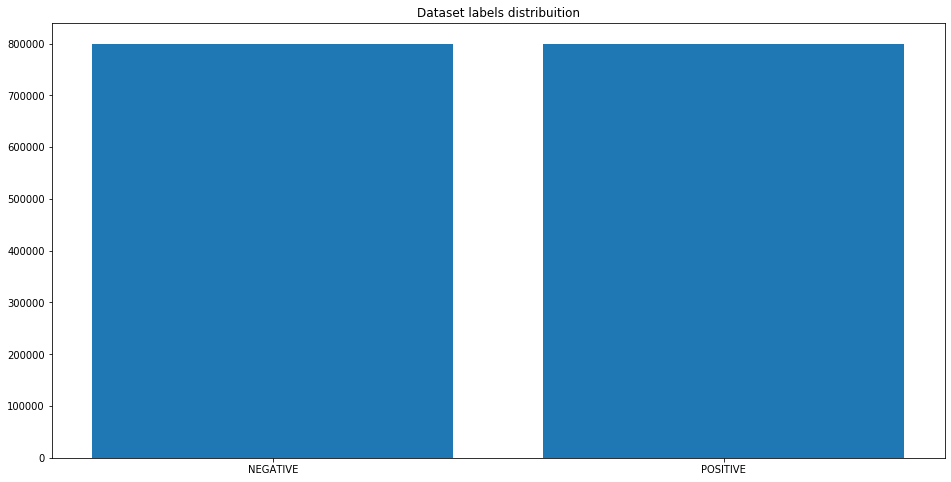

In [15]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [16]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [17]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 35.6 s, sys: 239 ms, total: 35.9 s
Wall time: 35.9 s


### Split train and test

In [19]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [20]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 2.34 s, sys: 176 ms, total: 2.52 s
Wall time: 2.52 s


In [21]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [22]:
w2v_model.build_vocab(documents)

2020-02-26 18:33:10,170 : INFO : collecting all words and their counts
2020-02-26 18:33:10,171 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-02-26 18:33:10,193 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-02-26 18:33:10,210 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-02-26 18:33:10,233 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-02-26 18:33:10,260 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-02-26 18:33:10,278 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-02-26 18:33:10,306 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-02-26 18:33:10,327 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-02-26 18:33:10,347 : INFO : PROGRESS: at s

2020-02-26 18:33:11,691 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-02-26 18:33:11,710 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-02-26 18:33:11,729 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-02-26 18:33:11,748 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-02-26 18:33:11,767 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-02-26 18:33:11,787 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-02-26 18:33:11,806 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-02-26 18:33:11,825 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-02-26 18:33:11,845 : INFO : PROGRESS: at sentence #800000, processed 577088

In [23]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [25]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-02-26 18:34:17,925 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-02-26 18:34:18,961 : INFO : EPOCH 1 - PROGRESS: at 8.36% examples, 679931 words/s, in_qsize 16, out_qsize 1
2020-02-26 18:34:19,974 : INFO : EPOCH 1 - PROGRESS: at 17.89% examples, 726808 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:34:20,979 : INFO : EPOCH 1 - PROGRESS: at 26.88% examples, 730080 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:34:22,002 : INFO : EPOCH 1 - PROGRESS: at 36.40% examples, 739250 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:34:23,028 : INFO : EPOCH 1 - PROGRESS: at 46.02% examples, 745976 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:34:24,029 : INFO : EPOCH 1 - PROGRESS: at 55.10% examples, 746270 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:34:25,057 : INFO : EPOCH 1 - PROGRESS: at 64.73% examples, 749868 words/s, in_qsize 12, out_qsize 3
2020-02-26 18:34:26,090 : INFO : EPOCH 1 - PROGRESS: 

2020-02-26 18:35:03,451 : INFO : EPOCH 5 - PROGRESS: at 17.35% examples, 706329 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:04,460 : INFO : EPOCH 5 - PROGRESS: at 26.34% examples, 715140 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:35:05,462 : INFO : EPOCH 5 - PROGRESS: at 35.86% examples, 731971 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:35:06,466 : INFO : EPOCH 5 - PROGRESS: at 45.81% examples, 748813 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:07,476 : INFO : EPOCH 5 - PROGRESS: at 55.32% examples, 753466 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:08,478 : INFO : EPOCH 5 - PROGRESS: at 64.40% examples, 752520 words/s, in_qsize 15, out_qsize 2
2020-02-26 18:35:09,489 : INFO : EPOCH 5 - PROGRESS: at 74.16% examples, 757607 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:10,493 : INFO : EPOCH 5 - PROGRESS: at 83.72% examples, 760174 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:11,537 : INFO : EPOCH 5 - PROGRESS: at 92.94% examples, 756460 words/s,

2020-02-26 18:35:48,480 : INFO : EPOCH 9 - PROGRESS: at 27.53% examples, 741395 words/s, in_qsize 13, out_qsize 2
2020-02-26 18:35:49,489 : INFO : EPOCH 9 - PROGRESS: at 37.05% examples, 750263 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:50,507 : INFO : EPOCH 9 - PROGRESS: at 46.89% examples, 759413 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:51,537 : INFO : EPOCH 9 - PROGRESS: at 56.73% examples, 764163 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:52,543 : INFO : EPOCH 9 - PROGRESS: at 64.84% examples, 749911 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:53,551 : INFO : EPOCH 9 - PROGRESS: at 73.51% examples, 744618 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:35:54,572 : INFO : EPOCH 9 - PROGRESS: at 82.96% examples, 746163 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:35:55,581 : INFO : EPOCH 9 - PROGRESS: at 91.42% examples, 740437 words/s, in_qsize 16, out_qsize 0
2020-02-26 18:35:56,375 : INFO : worker thread finished; awaiting finish of 7 more threa

2020-02-26 18:36:34,038 : INFO : EPOCH 13 - PROGRESS: at 46.89% examples, 760001 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:36:35,042 : INFO : EPOCH 13 - PROGRESS: at 56.51% examples, 764861 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:36:36,046 : INFO : EPOCH 13 - PROGRESS: at 65.72% examples, 763368 words/s, in_qsize 13, out_qsize 2
2020-02-26 18:36:37,059 : INFO : EPOCH 13 - PROGRESS: at 75.35% examples, 765808 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:36:38,092 : INFO : EPOCH 13 - PROGRESS: at 84.04% examples, 757210 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:36:39,108 : INFO : EPOCH 13 - PROGRESS: at 92.83% examples, 752403 words/s, in_qsize 11, out_qsize 4
2020-02-26 18:36:39,793 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-02-26 18:36:39,796 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-02-26 18:36:39,799 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-02-26 18:36:39,800 : INFO : work

2020-02-26 18:37:18,860 : INFO : EPOCH 17 - PROGRESS: at 47.43% examples, 772340 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:37:19,867 : INFO : EPOCH 17 - PROGRESS: at 56.95% examples, 773502 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:37:20,885 : INFO : EPOCH 17 - PROGRESS: at 66.25% examples, 770517 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:37:21,893 : INFO : EPOCH 17 - PROGRESS: at 76.66% examples, 780229 words/s, in_qsize 13, out_qsize 2
2020-02-26 18:37:22,898 : INFO : EPOCH 17 - PROGRESS: at 86.42% examples, 782121 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:37:23,909 : INFO : EPOCH 17 - PROGRESS: at 96.10% examples, 782329 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:37:24,221 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-02-26 18:37:24,236 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-02-26 18:37:24,241 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-02-26 18:37:24,250 : INFO : work

2020-02-26 18:38:03,368 : INFO : EPOCH 21 - PROGRESS: at 57.81% examples, 782416 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:38:04,368 : INFO : EPOCH 21 - PROGRESS: at 67.24% examples, 781300 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:38:05,371 : INFO : EPOCH 21 - PROGRESS: at 76.77% examples, 781354 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:38:06,381 : INFO : EPOCH 21 - PROGRESS: at 86.10% examples, 778694 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:38:07,388 : INFO : EPOCH 21 - PROGRESS: at 95.66% examples, 778637 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:38:07,786 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-02-26 18:38:07,793 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-02-26 18:38:07,799 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-02-26 18:38:07,801 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-26 18:38:07,802 : INFO : worker thread finished; awai

2020-02-26 18:38:48,401 : INFO : EPOCH 25 - PROGRESS: at 72.43% examples, 731323 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:38:49,418 : INFO : EPOCH 25 - PROGRESS: at 81.23% examples, 728809 words/s, in_qsize 15, out_qsize 0
2020-02-26 18:38:50,429 : INFO : EPOCH 25 - PROGRESS: at 90.32% examples, 729902 words/s, in_qsize 16, out_qsize 1
2020-02-26 18:38:51,333 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-02-26 18:38:51,344 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-02-26 18:38:51,348 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-02-26 18:38:51,351 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-26 18:38:51,354 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-26 18:38:51,372 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-26 18:38:51,376 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-26 18:38:5

2020-02-26 18:39:33,357 : INFO : EPOCH 29 - PROGRESS: at 92.94% examples, 754586 words/s, in_qsize 14, out_qsize 1
2020-02-26 18:39:33,996 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-02-26 18:39:34,003 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-02-26 18:39:34,004 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-02-26 18:39:34,016 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-02-26 18:39:34,017 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-02-26 18:39:34,028 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-02-26 18:39:34,042 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-02-26 18:39:34,043 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-02-26 18:39:34,044 : INFO : EPOCH - 29 : training on 9227204 raw words (8222084 effective words) took 10.8s, 760314 effective words/s
2020-02-26 18:39:3

CPU times: user 25min 45s, sys: 6.32 s, total: 25min 51s
Wall time: 5min 50s


(263125845, 295270528)

In [26]:
w2v_model.most_similar("love")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-02-26 18:42:47,385 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5717260837554932),
 ('loves', 0.558630645275116),
 ('loved', 0.5431678295135498),
 ('adore', 0.5245904326438904),
 ('amazing', 0.5016398429870605),
 ('looove', 0.4788050055503845),
 ('awesome', 0.4703221917152405),
 ('loooove', 0.4682392477989197),
 ('loveee', 0.45412003993988037),
 ('loove', 0.44265955686569214)]

### Tokenize Text

In [27]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 18.3 s, sys: 92 ms, total: 18.4 s
Wall time: 18.4 s


In [28]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 27.6 s, sys: 1.04 s, total: 28.6 s
Wall time: 28.7 s


### Label Encoder 

In [29]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [30]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [31]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [32]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [33]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [34]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [35]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2020-02-26 18:47:18,015 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87125700  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [37]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [38]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1150976/1152000 [============================>.] - ETA: 0s - loss: 0.5048 - accuracy: 0.7493WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-02-26 18:55:25,661 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1152000/1152000 [==============================] - 462s 401us/sample - loss: 0.5048 - accuracy: 0.7494 - val_loss: 0.4650 - val_accuracy: 0.7798
Epoch 2/8
1150976/1152000 [============================>.] - ETA: 0s - loss: 0.4795 - accuracy: 0.7673WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-02-26 19:02:56,364 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1152000/1152000 [==============================] - 451s 391us/sample - loss: 0.4795 - accuracy: 0.7674 - val_loss: 0.4575 - val_accuracy: 0.7842
Epoch 3/8
 796672/1152000 [===================>..........] - ETA: 2:14 - loss: 0.4752 - accuracy: 0.7702WARNING:tensorflow:Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


2020-02-26 19:07:56,948 : WARNING : Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


2020-02-26 19:07:56,950 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,lr


KeyboardInterrupt: 

### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)